In [1012]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [1013]:
tickers = ['AAPL']
data = yf.download(tickers, start = '2024-01-01', end = '2025-5-02')
data = data['Close']
df = pd.DataFrame(data)
df.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2025-04-23,204.600006
2025-04-24,208.369995
2025-04-25,209.279999
2025-04-28,210.139999
2025-04-29,211.210007


In [1014]:
df['Log Returns'] = np.log(df['AAPL']/df['AAPL'].shift(1))
df = df.dropna()
df.tail(10)

Ticker,AAPL,Log Returns
Date,,
2025-04-15,202.139999,-0.001878
2025-04-16,194.270004,-0.039712
2025-04-17,196.979996,0.013853
2025-04-21,193.160004,-0.019583
2025-04-22,199.740005,0.033498
2025-04-23,204.600006,0.024040
2025-04-24,208.369995,0.018258
2025-04-25,209.279999,0.004358
2025-04-28,210.139999,0.004101


Calculating the Parameters

In [1015]:
S_0 = float(df['AAPL'].iloc[-9])
print(f'S0 Value: {S_0}')
sigma_annual = float((df['Log Returns'].std())*np.sqrt(252))
print(f'Sigma Annual: {sigma_annual}')

S0 Value: 194.27000427246094
Sigma Annual: 0.2995794252427542


In [1016]:
t_bills = yf.download("^IRX", start="2024-01-01", end="2025-04-17")
r = float(t_bills['Close'].iloc[-1]/100)
print(f'Risk-Free Rate: {r}')

[*********************100%***********************]  1 of 1 completed

Risk-Free Rate: 0.04208000183105469



C:\Users\LiamRodgers\AppData\Local\Temp\ipykernel_26112\1677575590.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r = float(t_bills['Close'].iloc[-1]/100)


In [1017]:
print(f'S_0: {S_0}\nSigma Annual: {sigma_annual}\nRisk Free Rate: {r} ')

S_0: 194.27000427246094
Sigma Annual: 0.2995794252427542
Risk Free Rate: 0.04208000183105469 


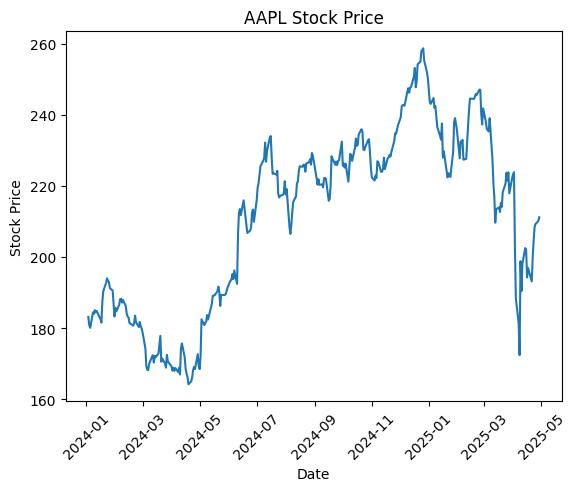

In [1018]:
plt.plot(df.index, df['AAPL'])
plt.title('AAPL Stock Price')
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.show()

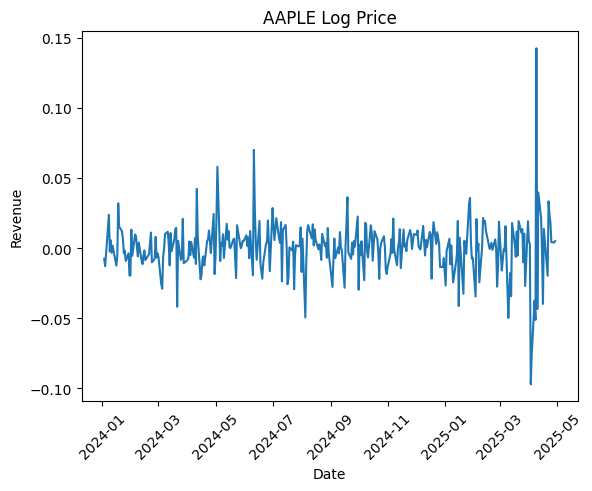

In [1019]:
plt.plot(df.index, df['Log Returns'])
plt.title('AAPLE Log Price')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.show()

Binomial Tree Model

In [1020]:
def binomial_american_option(S0, K, T, r, sigma, N, option_type="put", american=True):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # Option values at maturity
    if option_type == "call":
        V = np.maximum(ST - K, 0)
    else:
        V = np.maximum(K - ST, 0)

    # Step backward through tree
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            ST_i = S0 * (u ** i) * (d ** (t - i))
            exercise = max(K - ST_i, 0) if option_type == "put" else max(ST_i - K, 0)
            hold = np.exp(-r * dt) * (q * V[i + 1] + (1 - q) * V[i])
            V[i] = max(exercise, hold) if american else hold

    return V[0]

In [1021]:
K = 195       # strike price (adjust if needed)
T = 1 / 12    # 1 month to expiration this should not be fixed, so the T needs to be different each day
N = 100       # time steps
option_type = "put"

price = binomial_american_option(S_0, K, T, r, sigma_annual, N, option_type=option_type)

print(f"""S_0: {S_0}
Sigma Annual: {sigma_annual}
Risk Free Rate: {r}

Binomial American {option_type.title()} Option Price: {price:.4f}
""")

S_0: 194.27000427246094
Sigma Annual: 0.2995794252427542
Risk Free Rate: 0.04208000183105469

Binomial American Put Option Price: 6.7821



In [1022]:
for steps in [25, 50, 100, 200]:
    p = binomial_american_option(S_0, K, T, r, sigma_annual, steps, option_type)
    print(f"Steps: {steps}, Price: {p:.4f}")

Steps: 25, Price: 6.8373
Steps: 50, Price: 6.7809
Steps: 100, Price: 6.7821
Steps: 200, Price: 6.7803


The Greeks

In [1023]:
h = 0.1 #stock bump
price_up = binomial_american_option(S_0 + h, K, T, r, sigma_annual, N, option_type=option_type)
price_down = binomial_american_option(S_0 - h, K, T, r, sigma_annual, N, option_type=option_type)

In [1024]:
Delta = (price_up-price_down)/2*h
Gamma = (price_up - 2*price + price_down)/h**2
print(f'Delta: {Delta}\nGamma: {Gamma}')

Delta: -0.005094110997569912
Gamma: 0.0015888990270163104


In [1025]:
change = 5 #h value which is the change in the stock price
stock_prices = np.linspace(S_0 - change, S_0 + change, 20)
deltas = []
gammas = []

for S in stock_prices:
    price_up = binomial_american_option(S + h, K, T, r, sigma_annual, N, option_type=option_type)
    price_down = binomial_american_option(S - h, K, T, r, sigma_annual, N, option_type=option_type)
    price = binomial_american_option(S, K, T, r, sigma_annual, N, option_type=option_type)
    delta = (price_up - price_down) / (2 * h)
    gamma = (price_up - 2*price + price_down)/h**2 
    deltas.append(delta)
    gammas.append(gamma)

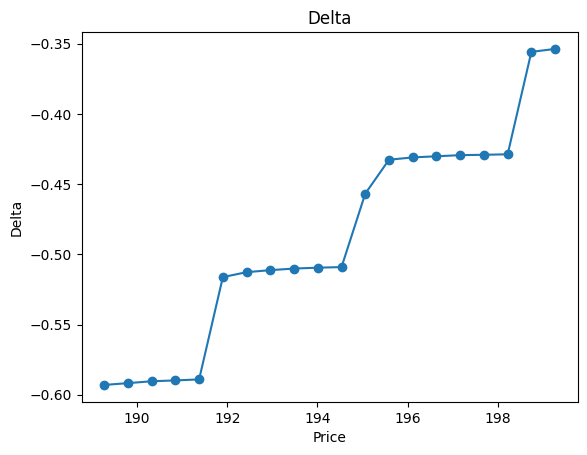

In [1026]:
plt.plot(stock_prices, deltas, marker = 'o')
plt.title('Delta')
plt.ylabel('Delta')
plt.xlabel('Price')
plt.show()

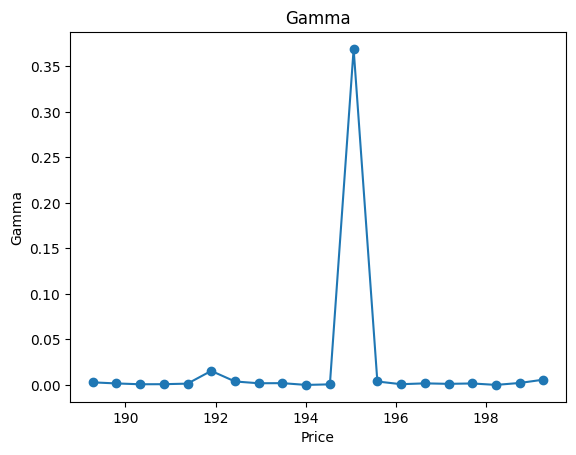

In [1027]:
plt.plot(stock_prices, gammas, marker = "o")
plt.title('Gamma')
plt.ylabel('Gamma')
plt.xlabel('Price')
plt.show()

The Smile

In [1028]:
#Look back window.
df_128 = df['2024-10-11':]
sigma_128 = df_128['Log Returns'].std()*np.sqrt(252)
print(sigma_128)
df_63 = df['2025-01-15':] # 63 trading days
sigma_64 = df_63['Log Returns'].std()*np.sqrt(252)
print(sigma_64)
df_20 = df['2025-03-20':]
sigma_20 = df_20['Log Returns'].std()*np.sqrt(252)
print(sigma_20)
df_20.shape


0.37078218212252434
0.48407715025833065
0.6811553400870339


(28, 2)

In [1029]:
df_sigmas = pd.DataFrame({
    
    'Sigma 128': [sigma_128],
    'Sigma 64': [sigma_64],
    'Sigma 20': [sigma_20],
    'sigma_annual' : [sigma_annual]
    
}).T
df_sigmas#.to_clipboard()


,0
Sigma 128,0.370782
Sigma 64,0.484077
Sigma 20,0.681155
sigma_annual,0.299579


In [1030]:
#Option prices with experation 25-Apr-2025
spot_price = S_0
moneyness = np.array([0.90, 0.95, 0.975, 1.00, 1.025, 1.05, 1.10, 1.20, 1.30])
implied_vols = np.array([58.77, 51.97, 48.65, 46.13, 43.78, 42.47, 40.86, 47.54, 54.26]) / 100  # Bloomberg values
strikes = moneyness * spot_price


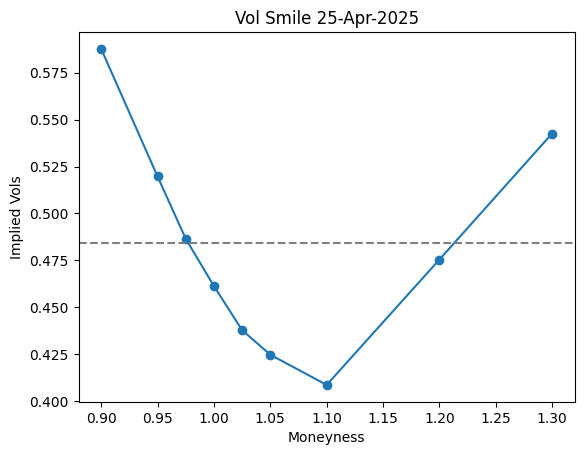

In [1031]:
plt.plot(moneyness, implied_vols, marker = 'o')
plt.axhline(y=sigma_64, color='grey', linestyle='--', label='3-Month Vol (64 days)')

plt.title('Vol Smile 25-Apr-2025')
plt.xlabel('Moneyness')
plt.ylabel('Implied Vols')
plt.show()

In [1032]:
#Option prices with experation 2-May-2025
spot_price = S_0
moneyness_may = np.array([0.90, 0.95, 0.975, 1.00, 1.025, 1.05, 1.10, 1.20, 1.30])
implied_vols_may = np.array([59.90, 55.03, 52.83, 50.77, 48.78, 46.82, 43.56, 44.54, 48.91]) / 100  # Bloomberg values
strikes = moneyness * spot_price

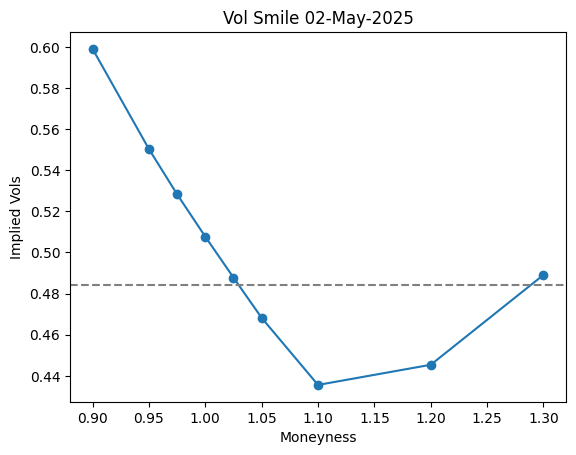

In [1033]:
plt.plot(moneyness_may, implied_vols_may, marker = 'o')
plt.axhline(y=sigma_64, color='grey', linestyle='--', label='3-Month Vol (64 days)')
plt.title('Vol Smile 02-May-2025')
plt.xlabel('Moneyness')
plt.ylabel('Implied Vols')
plt.show()

Hedging Exercise

In [1034]:
df_hedging = df[-9:]
two_week_vol = df_hedging['Log Returns'].std()*np.sqrt(252)
print(f"Two Week Annulaize Vol: {two_week_vol}")

Two Week Annulaize Vol: 0.356442349906921


In [1035]:
deltas_hedge = []
gammas_hedge = []
dates = []
h = 0.1  # small value for central difference

# Set constants
K = 195
r = r
sigma = two_week_vol
N = 100  # binomial tree steps
option_type = 'call'
total_days_to_expiry = (df_hedging.index[-1] - df_hedging.index[0]).days



In [1036]:
df_hedging.index

DatetimeIndex(['2025-04-16', '2025-04-17', '2025-04-21', '2025-04-22',
               '2025-04-23', '2025-04-24', '2025-04-25', '2025-04-28',
               '2025-04-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [1037]:
new_dates = pd.date_range(start='2025-04-16', end='2025-05-02')
new_dates

DatetimeIndex(['2025-04-16', '2025-04-17', '2025-04-18', '2025-04-19',
               '2025-04-20', '2025-04-21', '2025-04-22', '2025-04-23',
               '2025-04-24', '2025-04-25', '2025-04-26', '2025-04-27',
               '2025-04-28', '2025-04-29', '2025-04-30', '2025-05-01',
               '2025-05-02'],
              dtype='datetime64[ns]', freq='D')

In [1038]:
stock_prices_hedge = np.array(df_hedging['AAPL'])
dates = new_dates
deltas = []
gammas_hedge = []
put_prices = []
days_until = []
deltas_hedge = []
pay_off_daily = []


In [1039]:
num_contracts = 1
shares_per_con = 1 #US standard per contract, found online
delta_hedge = []

In [1040]:
expiry_date = pd.to_datetime("2025-05-02")

for i in range(len(stock_prices_hedge)):
    S = stock_prices_hedge[i]
    days_left = (expiry_date - dates[i]).days
    if days_left <= 0: #Last date will be NaN since it is Maturity
        deltas.append(np.nan)
        gammas_hedge.append(np.nan)
        put_prices.append(np.nan)
        days_until.append(np.nan)
        pay_off_daily.append(np.nan)
        delta_hedge.append(np.nan)
        continue
    T = days_left / 252  # Time to maturity in years, update this to 34 days

    price_up = binomial_american_option(S + h, K, T, r, sigma_annual, N, option_type=option_type)
    price_down = binomial_american_option(S - h, K, T, r, sigma_annual, N, option_type=option_type)
    price = binomial_american_option(S, K, T, r, sigma_annual, N, option_type=option_type)

    delta = (price_up - price_down) / (2 * h)
    gamma = (price_up - 2 * price + price_down) / (h ** 2)
    put = price
    payoff = np.maximum(S-K, 0)
    hedge = (num_contracts*shares_per_con*delta)*-1

    deltas.append(delta)
    gammas_hedge.append(gamma)
    put_prices.append(put)
    days_until.append(days_left) 
    pay_off_daily.append(payoff)
    delta_hedge.append(hedge)

In [1041]:
print(delta_hedge)

[-0.4893904431177942, -0.5678519257310333, -0.4875021156730419, -0.6427632993998156, -0.7773182600631134, -0.8771622843680138, -0.8765865293999919, -0.912395465446707, -0.9398256738710487]


In [1049]:
df_hedging.loc[:, 'Delta'] = deltas
df_hedging.loc[:, 'Gamma'] = gammas_hedge
df_hedging.loc[:, 'Delta Hedge (# of Shares)'] = delta_hedge
df_hedging.loc[:, 'Call Price'] = put_prices
df_hedging.loc[:,'Days to Maturity'] = days_until
df_hedging.loc[:, 'Pay off Per Contract'] = pay_off_daily

df_hedging#.to_clipboard()

Ticker,AAPL,Log Returns,Delta,Gamma,Delta Hedge (# of Shares),Call Price,Days to Maturity,Pay off Per Contract
Date,,,,,,,,
2025-04-16,194.270004,-0.039712,0.489390,-1.332268e-12,-0.489390,5.755100,16,0.000000
2025-04-17,196.979996,0.013853,0.567852,6.217249e-13,-0.567852,7.034962,15,1.979996
2025-04-21,193.160004,-0.019583,0.487502,-1.776357e-13,-0.487502,4.805550,14,0.000000
2025-04-22,199.740005,0.033498,0.642763,1.776357e-13,-0.642763,8.328866,13,4.740005
2025-04-23,204.600006,0.024040,0.777318,5.329071e-13,-0.777318,11.660761,12,9.600006
2025-04-24,208.369995,0.018258,0.877162,1.776357e-13,-0.877162,14.613599,11,13.369995
2025-04-25,209.279999,0.004358,0.876587,-1.243450e-12,-0.876587,15.259385,10,14.279999
2025-04-28,210.139999,0.004101,0.912395,-7.105427e-13,-0.912395,15.905609,9,15.139999
2025-04-29,211.210007,0.005079,0.939826,-7.105427e-13,-0.939826,16.773493,8,16.210007


In [1048]:
#Replication Portfolio Close the postion on April 16th

df_hedge_port = pd.DataFrame()
df_hedge_port["AAPL"] = df_hedging['AAPL']
df_hedge_port['Port Value'] = (df_hedging['Call Price']) - (df_hedging['Delta']*df_hedging['AAPL']) #subtract to take a short position in the stock

df_hedge_port['Delta'] = df_hedging['Delta']
df_hedge_port['Call Price'] = df_hedging['Call Price']
print(df_hedge_port.columns)

#PnLs
df_hedge_port['PnL Hedged'] =  (df_hedge_port['Call Price'] - df_hedge_port['Call Price'].shift(1)) - (df_hedge_port['Delta'].shift(1) * (df_hedge_port['AAPL'] - df_hedge_port['AAPL'].shift(1)))
df_hedge_port['PnL UnHedged'] = (df_hedge_port['Call Price'] -  df_hedge_port['Call Price'].shift(1))
df_hedge_port#.to_clipboard()


Index(['AAPL', 'Port Value', 'Delta', 'Call Price'], dtype='object')


,AAPL,Port Value,Delta,Call Price,PnL Hedged,PnL UnHedged
Date,,,,,,
2025-04-16,194.270004,-89.318783,0.489390,5.755100,NaN,NaN
2025-04-17,196.979996,-104.820508,0.567852,7.034962,-0.046382,1.279862
2025-04-21,193.160004,-89.360361,0.487502,4.805550,-0.060222,-2.229412
2025-04-22,199.740005,-120.056679,0.642763,8.328866,0.315552,3.523317
2025-04-23,204.600006,-147.378560,0.777318,11.660761,0.208064,3.331894
2025-04-24,208.369995,-168.160702,0.877162,14.613599,0.022357,2.952838
2025-04-25,209.279999,-168.192642,0.876587,15.259385,-0.152434,0.645787
2025-04-28,210.139999,-175.825173,0.912395,15.905609,-0.107641,0.646224
2025-04-29,211.210007,-181.727094,0.939826,16.773493,-0.108386,0.867884


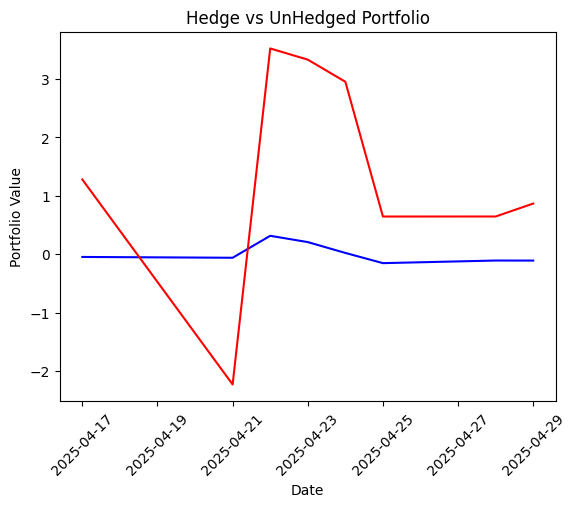

In [1044]:
plt.plot(df_hedge_port.index, df_hedge_port['PnL Hedged'], color = 'blue')
plt.plot(df_hedge_port.index, df_hedge_port['PnL UnHedged'], color = 'red')
plt.title('Hedge vs UnHedged Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.xticks(rotation = 45)
plt.show()

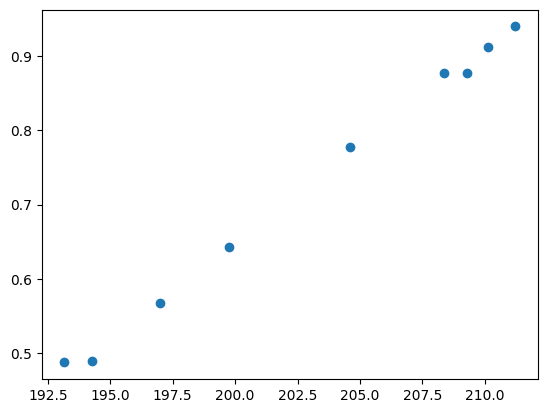

In [1045]:
plt.scatter(df_hedging['AAPL'], df_hedging['Delta'])
plt.show()

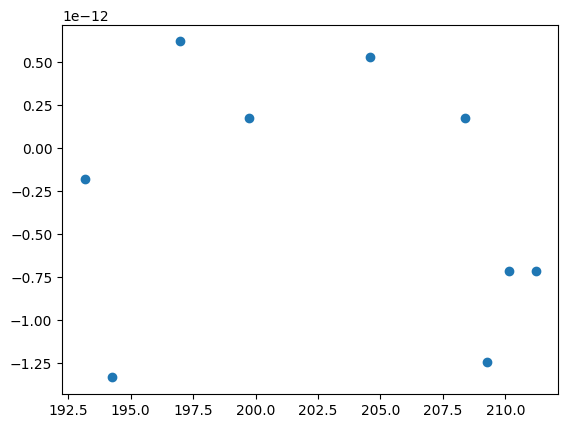

In [ ]:
plt.scatter(df_hedging['AAPL'], df_hedging['Gamma']) #Reached the limit of the binomial tree
plt.show()